# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

_Using the data set from the sales of 426k used cars and their associated attributes.  Determine which factors impact the sales price of a car?  Of particular interest will be the items a dealer can control about the car._

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

1. _Determeine the car sales data attributes_
2. _Determine the sales attribute on which we wish to train the model, likely sales price_
3. _Look at the Value Counts for each of the attributes deciding what to do with any or misrepresented data_
4. _Look for correlations between the outcome and any attributes_
5. _Break categorical data out into their own columns_

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor, ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [48]:
# Load the CSV file into a pandas DataFrame
vehicles_df = pd.read_csv('data/vehicles.csv')

#Display shape of the DataFrame
print(f"DataFrame shape: {vehicles_df.shape}")

# Display the first few rows of the DataFrame
vehicles_df.head()

DataFrame shape: (426880, 18)


,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


_Findings from reviewing the data_

1. _There appears to be a bunch of data with sales price, region, and state but without any other information (all NaNs).  This data should be dropped as it should be obvious that state, while a possible factor in the sales price of a car is not the most important factor._

2. _The VIN column should be dropped unless it can be tied to another database where further attributes can be obtained.  Since that is out of scope for this assignment, it will be dropped._

3. _The id column doesn't seem to serve a purpose so it should be dropped

4. _The region data has 403 distinct regions and is somewhat redundant with state.  Additionally some of the regions don't have a lot of sales, less than 0.1% of the data, making it unreliable to train a model.  Therfore it should just be dropped_

5. _The model data has over 9000 distint entries in a databse of ~79000 vehicls this makes it too variant to train larger model.  This data should be dropped as we have other information that contains duplicate information such as the type, transmission, drive, cylinders, and manufacturer._

6. _Certain entries in the data base have very few entries, less than 0.1%, of the total number and should be dropped as it wouldn't be robust to train a model on them._

7. _Converting the vehicle manufacture year to age seems more approprate.  For future use of the model._

8. _There are some obvious mistakes/outliers in the numerical data that need to be pruned for the data set to be useful.  There are clumps of car sales at a million dollars and odometers clumps at a million miles and 10M miles.  Its probably safe to drop anything above 1M miles_

In [49]:
# Drop the 'VIN' column and rows with NaN values
vehicles_df = vehicles_df.drop(columns=['VIN', 'id'])  # Drop the VIN column
vehicles_df = vehicles_df.dropna()  # Drop rows with NaN values

print(f"DataFrame shape: {vehicles_df.shape}")

vehicles_df

DataFrame shape: (79195, 16)


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
31,auburn,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,full-size,truck,black,al
55,auburn,19900,2004.0,ford,f250 super duty,good,8 cylinders,diesel,88000.0,clean,automatic,4wd,full-size,pickup,blue,al
59,auburn,14000,2012.0,honda,odyssey,excellent,6 cylinders,gas,95000.0,clean,automatic,fwd,full-size,mini-van,silver,al
65,auburn,22500,2001.0,ford,f450,good,8 cylinders,diesel,144700.0,clean,manual,rwd,full-size,truck,white,al
73,auburn,15000,2017.0,dodge,charger rt 4dr sedan,excellent,8 cylinders,gas,90000.0,rebuilt,automatic,rwd,mid-size,sedan,grey,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426808,wyoming,18000,2005.0,chevrolet,silverado 1500 lt 4x4,excellent,8 cylinders,gas,130000.0,lien,automatic,4wd,full-size,truck,blue,wy
426809,wyoming,18000,1990.0,jeep,gand wagoneer,good,8 cylinders,gas,114400.0,clean,automatic,4wd,full-size,SUV,black,wy
426831,wyoming,9800,1985.0,nissan,300zx coupe with t-tops,like new,6 cylinders,gas,115000.0,clean,automatic,rwd,sub-compact,hatchback,red,wy
426833,wyoming,6800,1997.0,jaguar,xk8 convertible,good,8 cylinders,gas,69550.0,clean,automatic,rwd,compact,convertible,white,wy


C:\Users\stepa\AppData\Local\Temp\ipykernel_56804\586068431.py:24: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\stepa\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


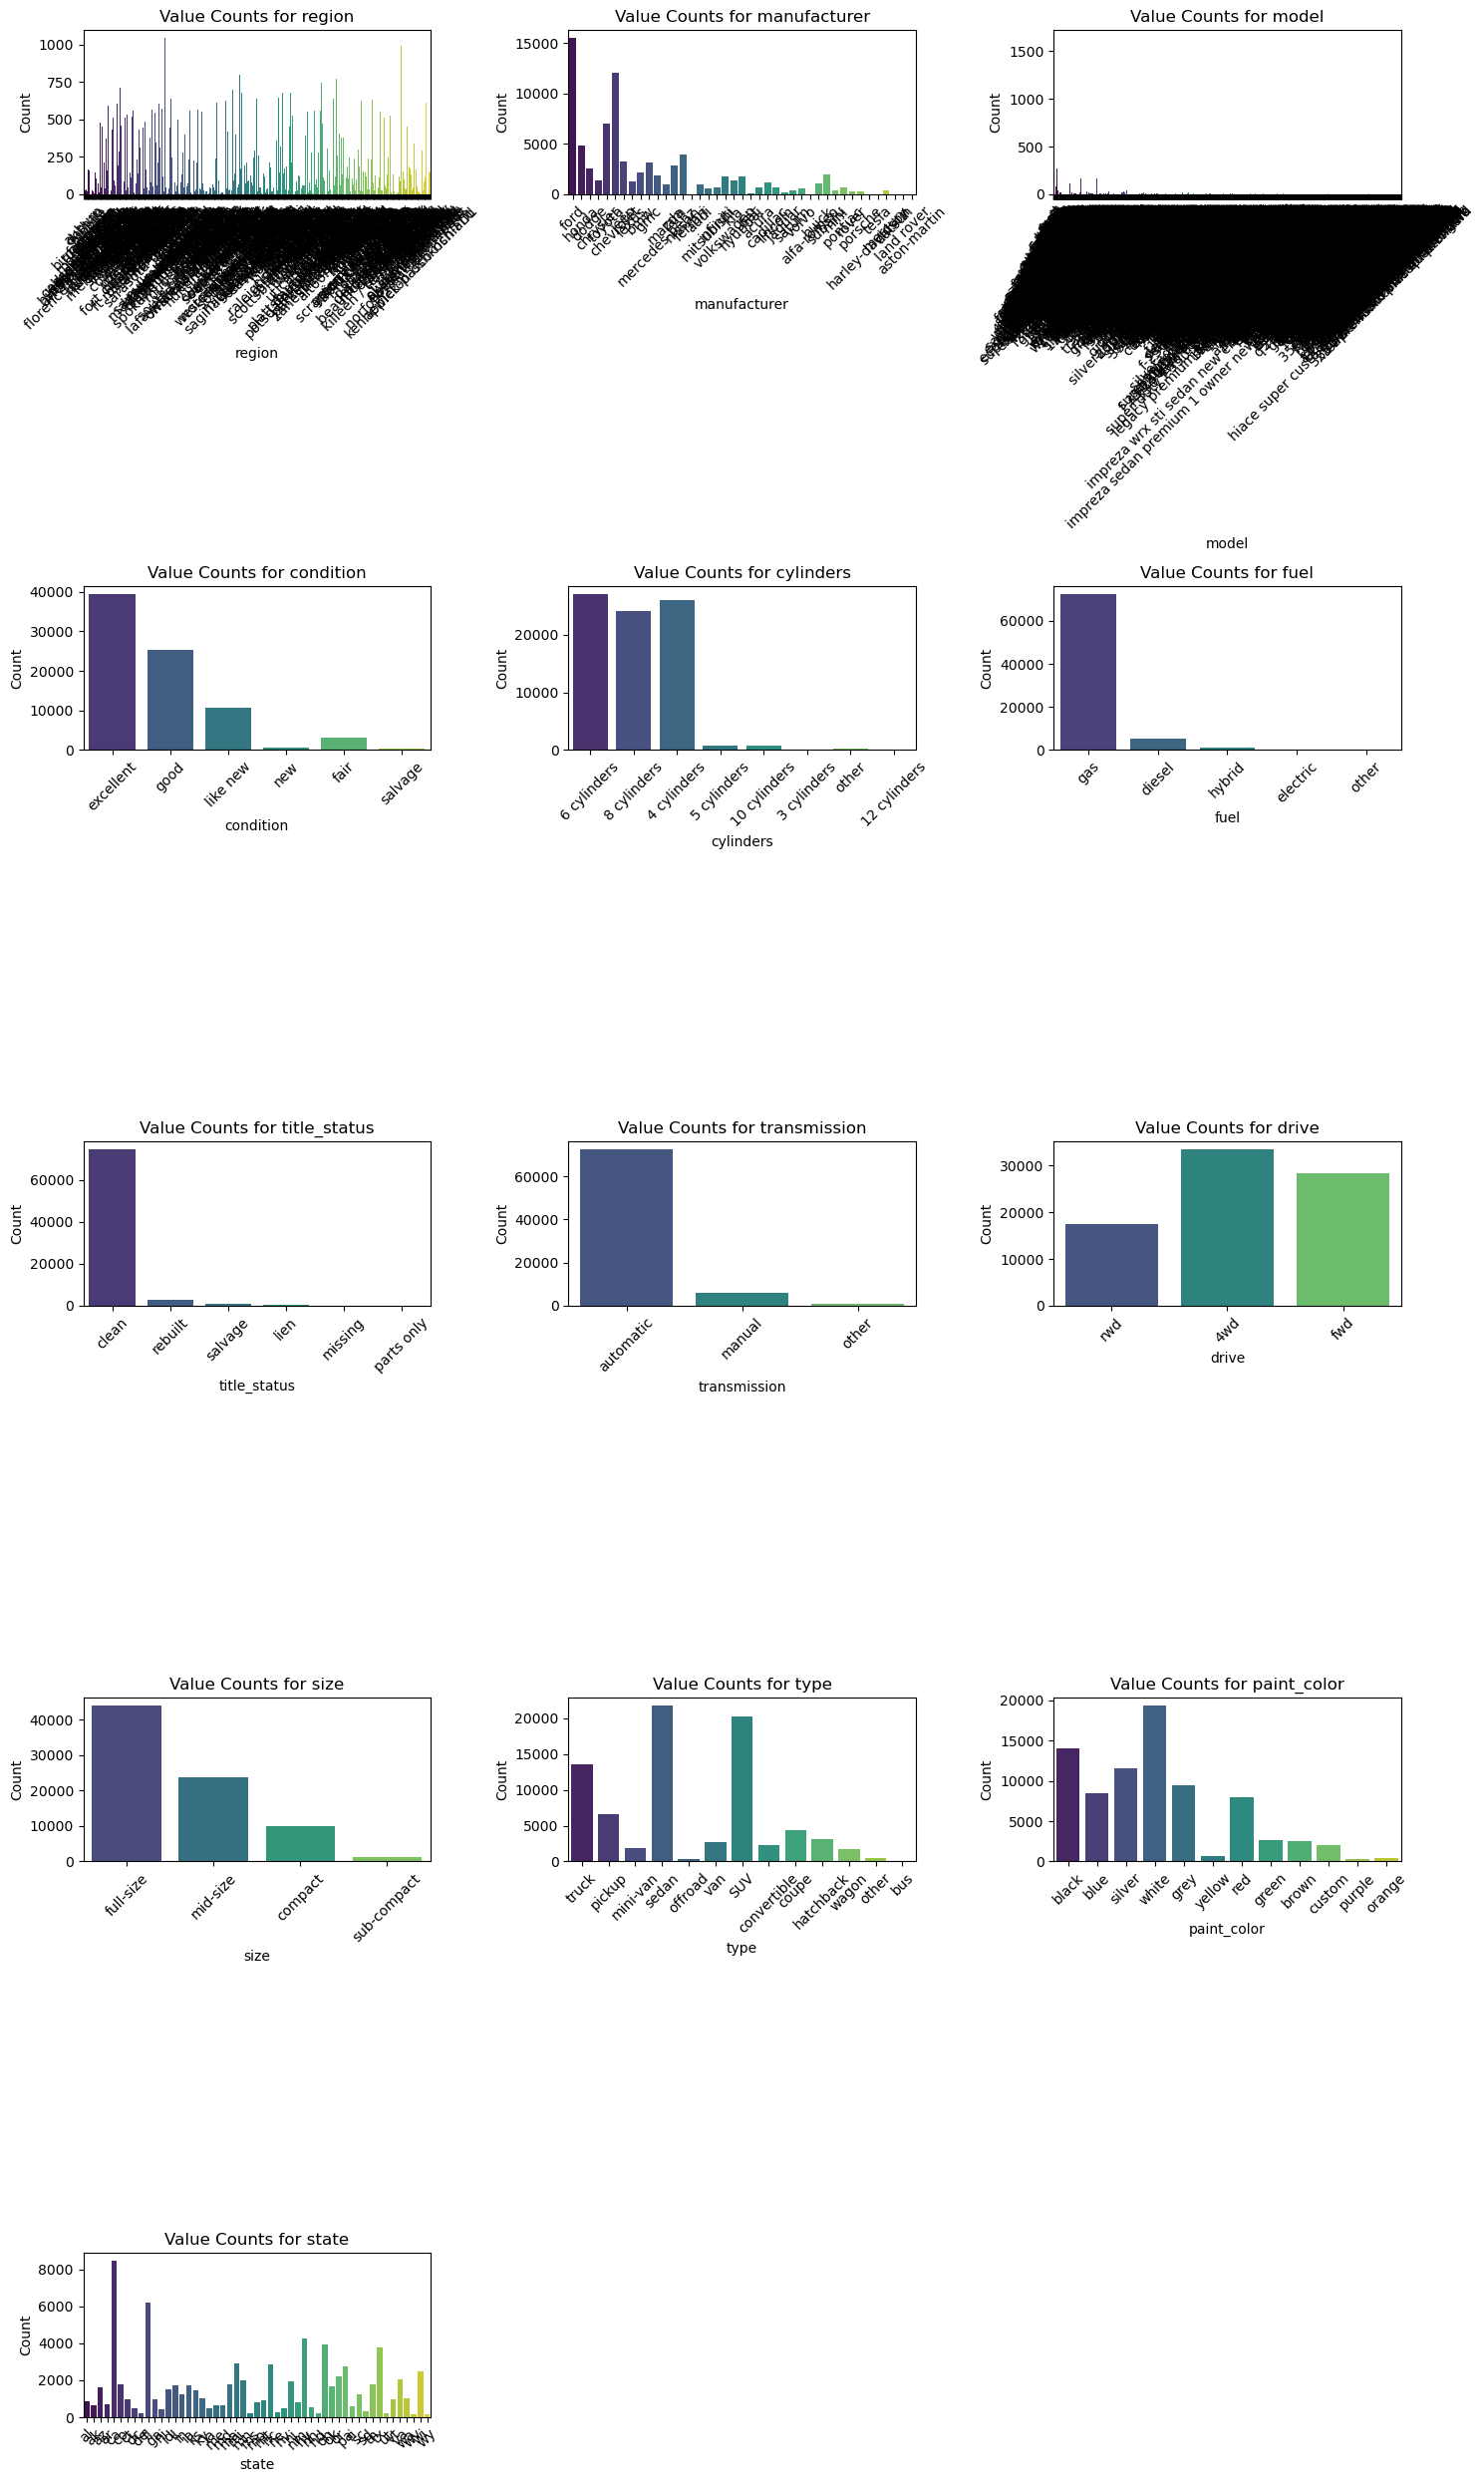

In [50]:

# Select categorical columns
categorical_columns = vehicles_df.select_dtypes(include=['object', 'category']).columns

# Set up the subplots
num_cols = 3  # Number of plots per row
num_rows = (len(categorical_columns) + num_cols - 1) // num_cols  # Calculate rows needed
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()  # Flatten axes for easy iteration

# Plot each categorical column
for i, column in enumerate(categorical_columns):
    sns.countplot(data=vehicles_df, x=column, ax=axes[i], palette="viridis", hue=column, legend=False)
    axes[i].set_title(f"Value Counts for {column}")
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=45)
    # Reduce the font size of x-axis labels
    #axes[i].set_xticklabels(axes[i].get_xticklabels(), fontsize=8)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [51]:
# Drop the 'VIN' column and rows with NaN values
vehicles_df = vehicles_df.drop(columns=['model', 'region'])  # Drop the VIN column



DataFrame shape: (78980, 14)


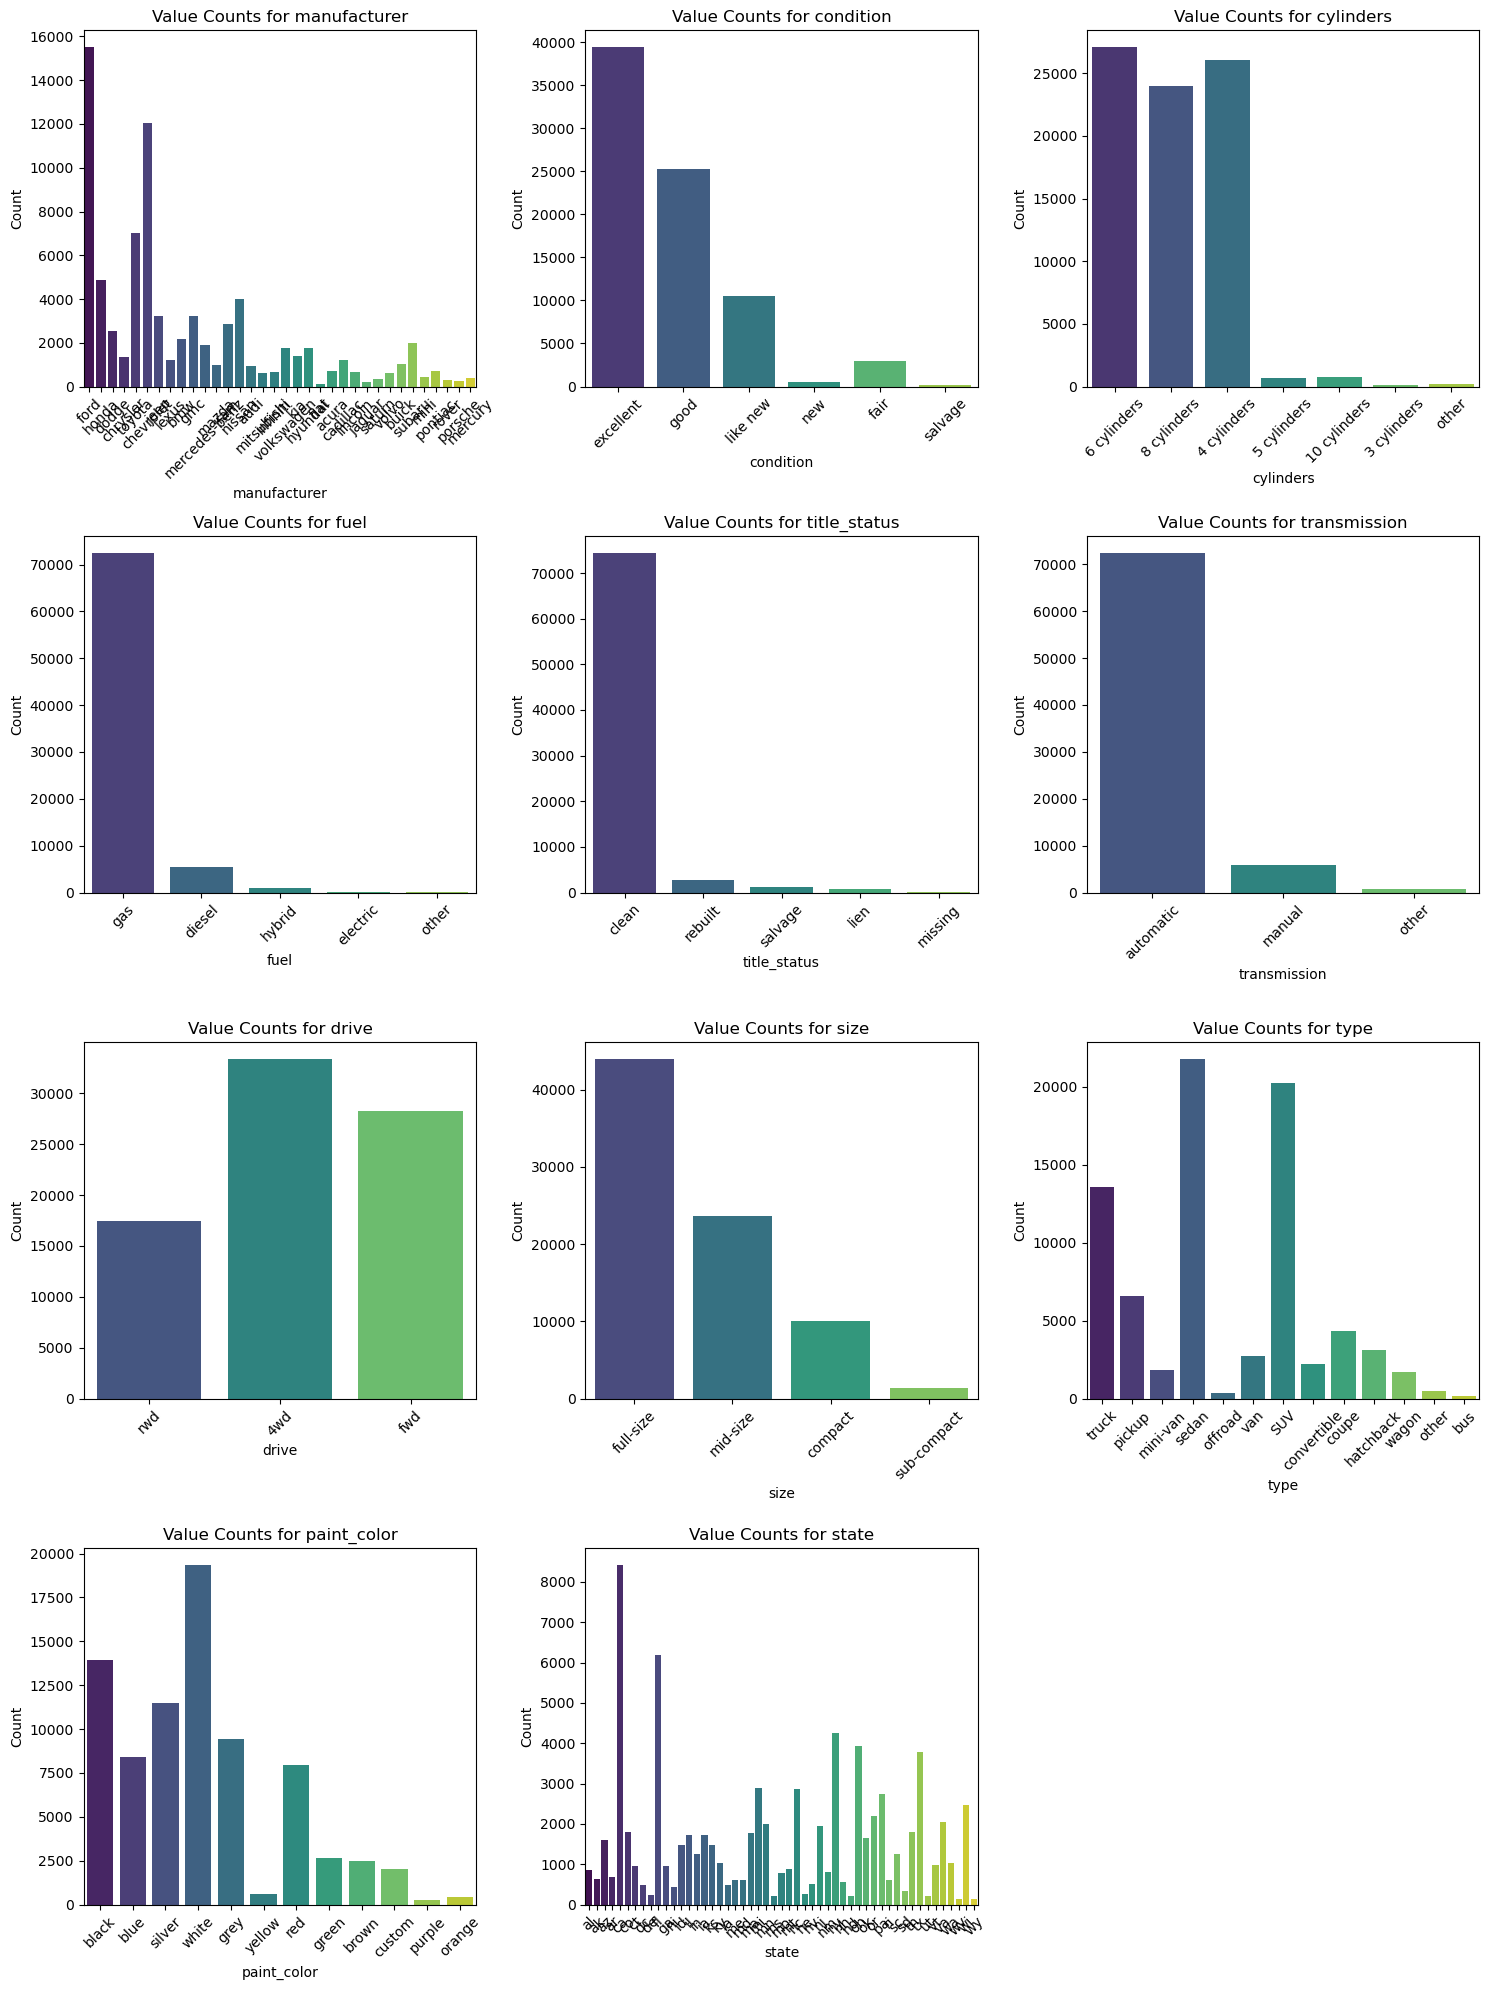

In [52]:
#drop anything witha value count less than 0.1% of the total amount

for column in vehicles_df.select_dtypes(include=['object', 'category']).columns:
    value_counts = vehicles_df[column].value_counts()
    valid_categories = value_counts[value_counts >= 79].index
    vehicles_df = vehicles_df[vehicles_df[column].isin(valid_categories)]

# Display the updated DataFrame
vehicles_df.head()

print(f"DataFrame shape: {vehicles_df.shape}")

#for column in vehicles_df.select_dtypes(include=['object', 'category']).columns:
#    print(f"Value counts for column: {column}")
#    print(vehicles_df[column].value_counts())
#    print("\n")

# Select categorical columns
categorical_columns = vehicles_df.select_dtypes(include=['object', 'category']).columns

# Set up the subplots
num_cols = 3  # Number of plots per row
num_rows = (len(categorical_columns) + num_cols - 1) // num_cols  # Calculate rows needed
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()  # Flatten axes for easy iteration

# Plot each categorical column
for i, column in enumerate(categorical_columns):
    sns.countplot(data=vehicles_df, x=column, ax=axes[i], palette="viridis", hue=column, legend=False)
    axes[i].set_title(f"Value Counts for {column}")
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=45)
    # Reduce the font size of x-axis labels
    #axes[i].set_xticklabels(axes[i].get_xticklabels(), fontsize=8)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()



In [53]:

# Display the updated DataFrame
vehicles_df

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
31,15000,2013.0,ford,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,full-size,truck,black,al
55,19900,2004.0,ford,good,8 cylinders,diesel,88000.0,clean,automatic,4wd,full-size,pickup,blue,al
59,14000,2012.0,honda,excellent,6 cylinders,gas,95000.0,clean,automatic,fwd,full-size,mini-van,silver,al
65,22500,2001.0,ford,good,8 cylinders,diesel,144700.0,clean,manual,rwd,full-size,truck,white,al
73,15000,2017.0,dodge,excellent,8 cylinders,gas,90000.0,rebuilt,automatic,rwd,mid-size,sedan,grey,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426808,18000,2005.0,chevrolet,excellent,8 cylinders,gas,130000.0,lien,automatic,4wd,full-size,truck,blue,wy
426809,18000,1990.0,jeep,good,8 cylinders,gas,114400.0,clean,automatic,4wd,full-size,SUV,black,wy
426831,9800,1985.0,nissan,like new,6 cylinders,gas,115000.0,clean,automatic,rwd,sub-compact,hatchback,red,wy
426833,6800,1997.0,jaguar,good,8 cylinders,gas,69550.0,clean,automatic,rwd,compact,convertible,white,wy


In [54]:
# Calculate the maximum year in the dataset
max_year = vehicles_df['year'].max()

# Replace the 'year' column with 'age'
vehicles_df['age'] = max_year - vehicles_df['year']

# Drop the original 'year' column
vehicles_df = vehicles_df.drop(columns=['year'])


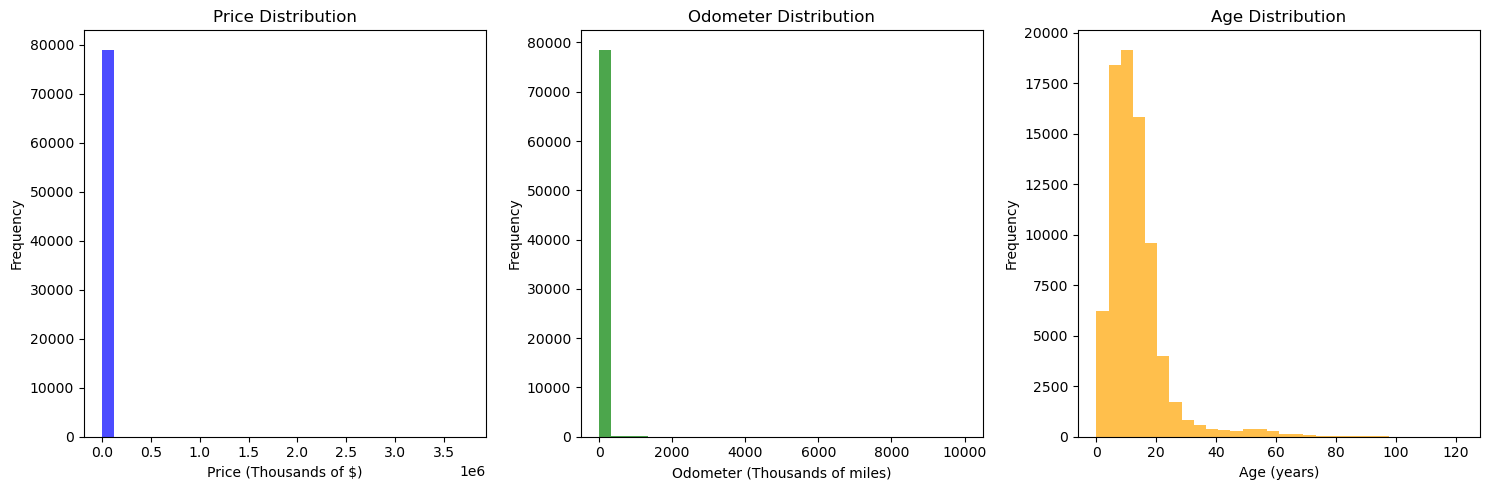

In [55]:
# Plot histograms for price (in thousands), odometer (in thousands), and age
plt.figure(figsize=(15, 5))

# Histogram for price (in thousands of dollars)
plt.subplot(1, 3, 1)
plt.hist(vehicles_df['price'] / 1000, bins=30, color='blue', alpha=0.7)
plt.title('Price Distribution')
plt.xlabel('Price (Thousands of $)')
plt.ylabel('Frequency')

# Histogram for odometer (in thousands of miles)
plt.subplot(1, 3, 2)
plt.hist(vehicles_df['odometer'] / 1000, bins=30, color='green', alpha=0.7)
plt.title('Odometer Distribution')
plt.xlabel('Odometer (Thousands of miles)')
plt.ylabel('Frequency')

# Histogram for age
plt.subplot(1, 3, 3)
plt.hist(vehicles_df['age'], bins=30, color='orange', alpha=0.7)
plt.title('Age Distribution')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()

Number of Vehicles above $1M: 9


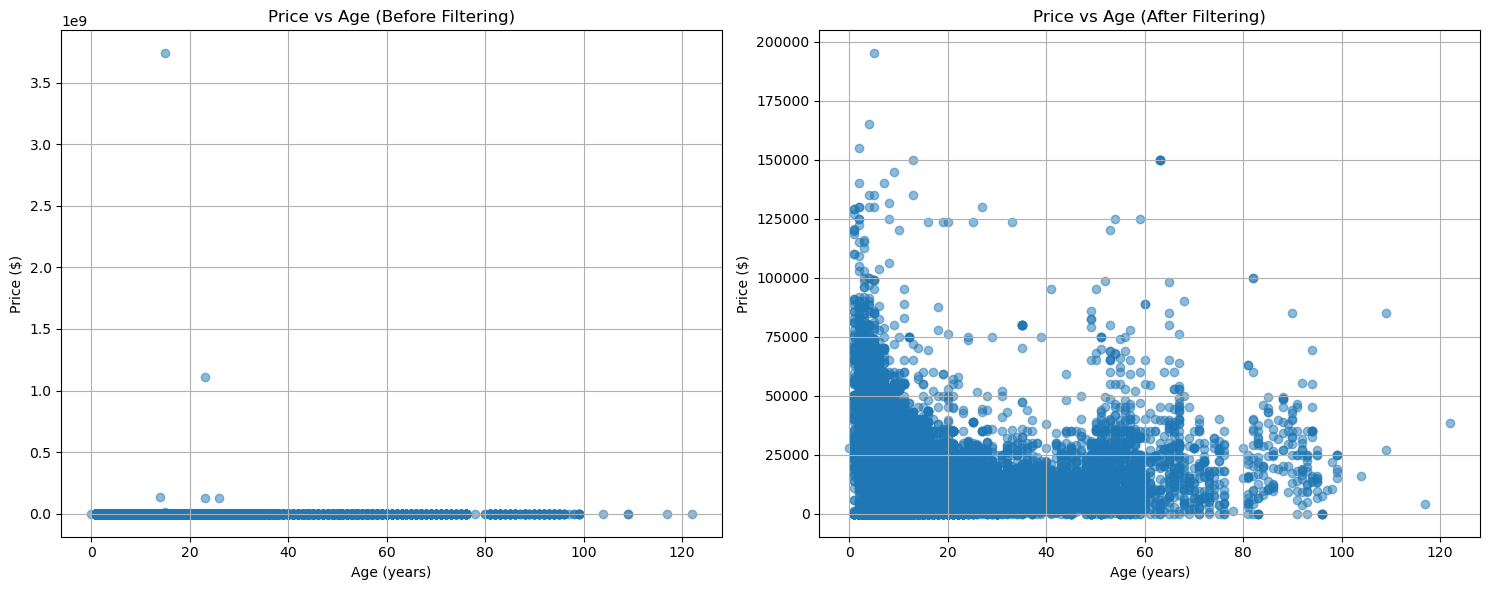

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot of price vs age (before filtering)
axes[0].scatter(vehicles_df['age'], vehicles_df['price'], alpha=0.5)
axes[0].set_title('Price vs Age (Before Filtering)')
axes[0].set_xlabel('Age (years)')
axes[0].set_ylabel('Price ($)')
axes[0].grid(True)

# Filter the DataFrame to include only rows where price <= 1,000,000
print("Number of Vehicles above $1M:", sum(vehicles_df['price'] > 1000000))
vehicles_df = vehicles_df[vehicles_df['price'] <= 1000000]

# Scatter plot of price vs age (after filtering)
axes[1].scatter(vehicles_df['age'], vehicles_df['price'], alpha=0.5)
axes[1].set_title('Price vs Age (After Filtering)')
axes[1].set_xlabel('Age (years)')
axes[1].set_ylabel('Price ($)')
axes[1].grid(True)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


Number of Vehicles above 1M miles: 43
Number of Vehicles above 950K miles: 151


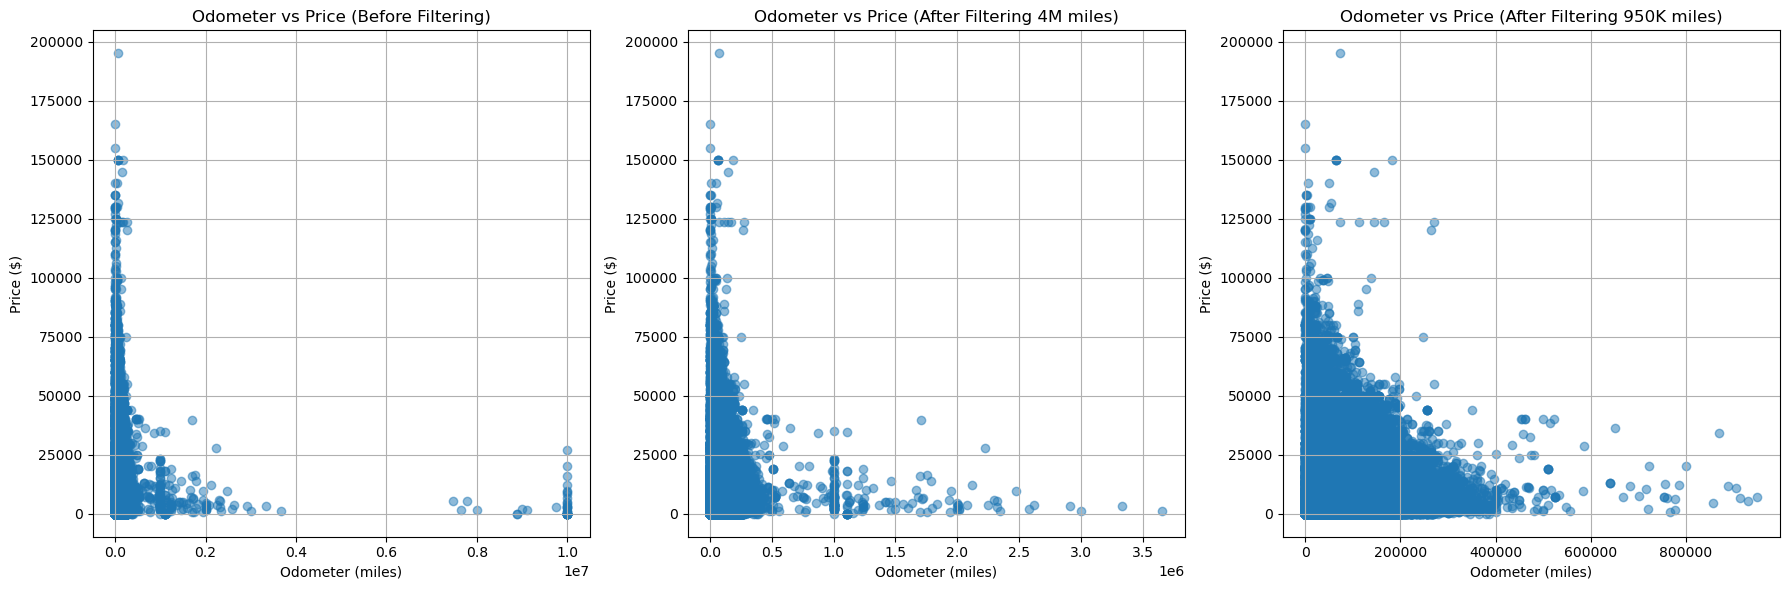

In [57]:

# Create subplots for scatter plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Scatter plot of odometer vs price (before filtering)
axes[0].scatter(vehicles_df['odometer'], vehicles_df['price'], alpha=0.5)
axes[0].set_title('Odometer vs Price (Before Filtering)')
axes[0].set_xlabel('Odometer (miles)')
axes[0].set_ylabel('Price ($)')
axes[0].grid(True)

# Filter the DataFrame to include only rows where odometer <= 4,000,000
print("Number of Vehicles above 1M miles:", sum(vehicles_df['odometer'] > 4_000_000))
vehicles_df = vehicles_df[vehicles_df['odometer'] <= 4_000_000]

# Scatter plot of odometer vs price (after filtering 4M miles)
axes[1].scatter(vehicles_df['odometer'], vehicles_df['price'], alpha=0.5)
axes[1].set_title('Odometer vs Price (After Filtering 4M miles)')
axes[1].set_xlabel('Odometer (miles)')
axes[1].set_ylabel('Price ($)')
axes[1].grid(True)

# Filter the DataFrame to include only rows where odometer <= 950,000
print("Number of Vehicles above 950K miles:", sum(vehicles_df['odometer'] > 950_000))
vehicles_df = vehicles_df[vehicles_df['odometer'] <= 950_000]

# Scatter plot of odometer vs price (after filtering 950K miles)
axes[2].scatter(vehicles_df['odometer'], vehicles_df['price'], alpha=0.5)
axes[2].set_title('Odometer vs Price (After Filtering 950K miles)')
axes[2].set_xlabel('Odometer (miles)')
axes[2].set_ylabel('Price ($)')
axes[2].grid(True)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

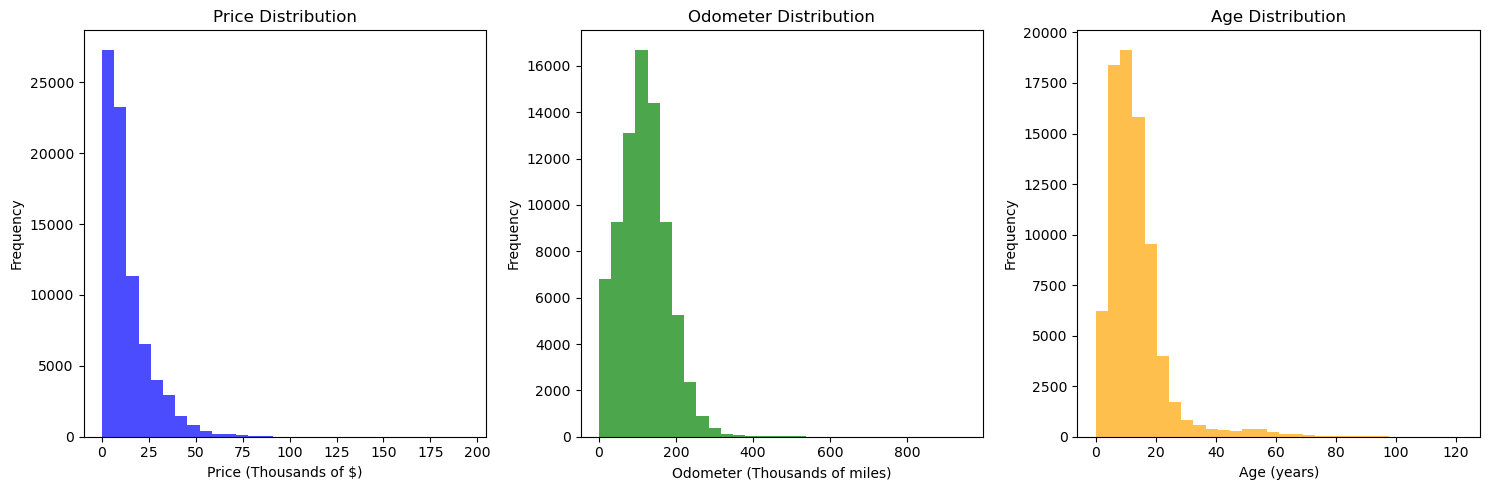

In [58]:
# Plot histograms for price (in thousands), odometer (in thousands), and age
plt.figure(figsize=(15, 5))

# Histogram for price (in thousands of dollars)
plt.subplot(1, 3, 1)
plt.hist(vehicles_df['price'] / 1000, bins=30, color='blue', alpha=0.7)
plt.title('Price Distribution')
plt.xlabel('Price (Thousands of $)')
plt.ylabel('Frequency')

# Histogram for odometer (in thousands of miles)
plt.subplot(1, 3, 2)
plt.hist(vehicles_df['odometer'] / 1000, bins=30, color='green', alpha=0.7)
plt.title('Odometer Distribution')
plt.xlabel('Odometer (Thousands of miles)')
plt.ylabel('Frequency')

# Histogram for age
plt.subplot(1, 3, 3)
plt.hist(vehicles_df['age'], bins=30, color='orange', alpha=0.7)
plt.title('Age Distribution')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()



In [59]:
print(vehicles_df.shape)

# Downsample the dataset to a smaller size for faster processing
vehicles_ds_df = vehicles_df.sample(n=16000, random_state=42)
print(vehicles_ds_df.shape)
vehicles_ds_df

(78777, 14)
(16000, 14)


,price,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,age
113044,5991,nissan,excellent,4 cylinders,gas,114415.0,clean,automatic,fwd,sub-compact,sedan,grey,fl,9.0
32657,27900,chevrolet,excellent,6 cylinders,gas,77905.0,clean,automatic,rwd,full-size,truck,red,ca,7.0
193061,9200,bmw,excellent,6 cylinders,gas,104250.0,clean,manual,rwd,compact,convertible,black,ma,19.0
272513,7795,hyundai,excellent,4 cylinders,gas,85843.0,clean,automatic,fwd,mid-size,sedan,grey,ny,9.0
112353,4200,dodge,fair,8 cylinders,gas,153000.0,clean,automatic,rwd,full-size,sedan,red,fl,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379295,19995,nissan,like new,4 cylinders,gas,7817.0,clean,automatic,fwd,compact,SUV,white,tx,2.0
422659,8995,honda,good,4 cylinders,gas,113000.0,clean,automatic,4wd,sub-compact,SUV,blue,wi,14.0
176836,9990,hyundai,excellent,4 cylinders,gas,90255.0,clean,automatic,fwd,compact,hatchback,grey,la,8.0
263984,23900,rover,excellent,4 cylinders,gas,60412.0,clean,automatic,4wd,full-size,SUV,black,ny,6.0


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [60]:
# Define the features and target
categorical_features = 	['manufacturer', 
                         'condition', 
                         'cylinders',	
                         'fuel',	
                         'title_status',
                         'transmission',	
                         'drive', 
                         'size', 
                         'type', 
                         'paint_color',	
                         'state']
                         
numerical_features = ['odometer', 'age']
target = 'price'

# Split the data into features (X) and target (y)
X = vehicles_ds_df[categorical_features + numerical_features]
y = vehicles_ds_df[target]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [61]:

# Define the preprocessor
def create_preprocessor(degree):
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('poly', PolynomialFeatures(degree=degree, include_bias=False)), 
                ('scaler', StandardScaler())
            ]), numerical_features),
            ('cat', OneHotEncoder(), categorical_features)
        ]
    )
    return preprocessor

# Define the Lasso pipeline
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', create_preprocessor(degree=2)),  # Initial degree (overridden by GridSearchCV)
    ('regressor', Lasso(random_state=42))
])

# Define the parameter grid for Lasso
lasso_param_grid = {
    'preprocessor__num__poly__degree': [1, 2, 3, 4, 5],  # Polynomial degrees
    'regressor__alpha': [0.01, 0.1, 1.0, 10, 100, 1000]  # Regularization strengths
}

# Perform GridSearchCV for Lasso
lasso_grid_search = GridSearchCV(lasso_pipeline, lasso_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
lasso_grid_search.fit(X_train, y_train)

# Print the best parameters and score for Lasso
print("Best Lasso Parameters:", lasso_grid_search.best_params_)
print("Best Lasso Score:", -lasso_grid_search.best_score_)

# Define the Ridge pipeline
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', create_preprocessor(degree=2)),  # Initial degree (overridden by GridSearchCV)
    ('regressor', Ridge(random_state=42))
])

# Define the parameter grid for Ridge
ridge_param_grid = {
    'preprocessor__num__poly__degree': [1, 2, 3, 4, 5],  # Polynomial degrees
    'regressor__alpha': [0.01, 0.1, 1.0, 10, 100, 1000]  # Regularization strengths
}

# Perform GridSearchCV for Ridge
ridge_grid_search = GridSearchCV(ridge_pipeline, ridge_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
ridge_grid_search.fit(X_train, y_train)

# Print the best parameters and score for Ridge
print("Best Ridge Parameters:", ridge_grid_search.best_params_)
print("Best Ridge Score:", -ridge_grid_search.best_score_)

c:\Users\stepa\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7201455359.429565, tolerance: 197916285.9792988
  model = cd_fast.sparse_enet_coordinate_descent(


Best Lasso Parameters: {'preprocessor__num__poly__degree': 3, 'regressor__alpha': 1.0}
Best Lasso Score: 69311865.4006665
Best Ridge Parameters: {'preprocessor__num__poly__degree': 5, 'regressor__alpha': 1.0}
Best Ridge Score: 69155162.04471847


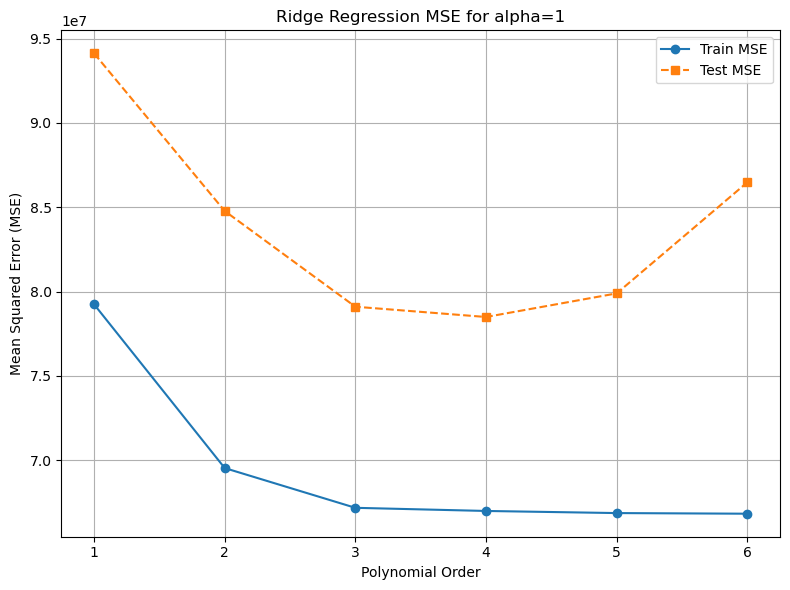

In [62]:
# List of polynomial orders to evaluate
orders = [1, 2, 3, 4, 5, 6]
alpha = 1  # Fixed alpha value

# Store results
train_mse_list = []
test_mse_list = []

for order in orders:
    # Update the Ridge pipeline with the current polynomial order
    ridge_pipeline.set_params(preprocessor__num__poly__degree=order, regressor__alpha=alpha)
    
    # Fit the pipeline to the training data
    ridge_pipeline.fit(X_train, y_train)
    
    # Predict on training and testing sets
    y_train_pred = ridge_pipeline.predict(X_train)
    y_test_pred = ridge_pipeline.predict(X_test)
    
    # Calculate MSE for training and testing sets
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    
    # Store the results
    train_mse_list.append(train_mse)
    test_mse_list.append(test_mse)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(orders, train_mse_list, label='Train MSE', marker='o', linestyle='-')
plt.plot(orders, test_mse_list, label='Test MSE', marker='s', linestyle='--')
plt.xlabel('Polynomial Order')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Ridge Regression MSE for alpha=1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

_4th Order poly fit should be suffient for our purposes.  The 5th order doesn't produce a benfit against the test set and is overtrained_

In [63]:
# Update the Ridge pipeline with the current polynomial order
lasso_pipeline.set_params(preprocessor__num__poly__degree=4, regressor__alpha=1)

# Fit the pipeline to the training data
lasso_pipeline.fit(X_train, y_train)

# Predict on training and testing sets
y_train_pred = ridge_pipeline.predict(X_train)
y_test_pred = ridge_pipeline.predict(X_test)





c:\Users\stepa\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 297583477784.7266, tolerance: 197916285.9792988
  model = cd_fast.sparse_enet_coordinate_descent(


c:\Users\stepa\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 297583477784.7266, tolerance: 197916285.9792988
  model = cd_fast.sparse_enet_coordinate_descent(


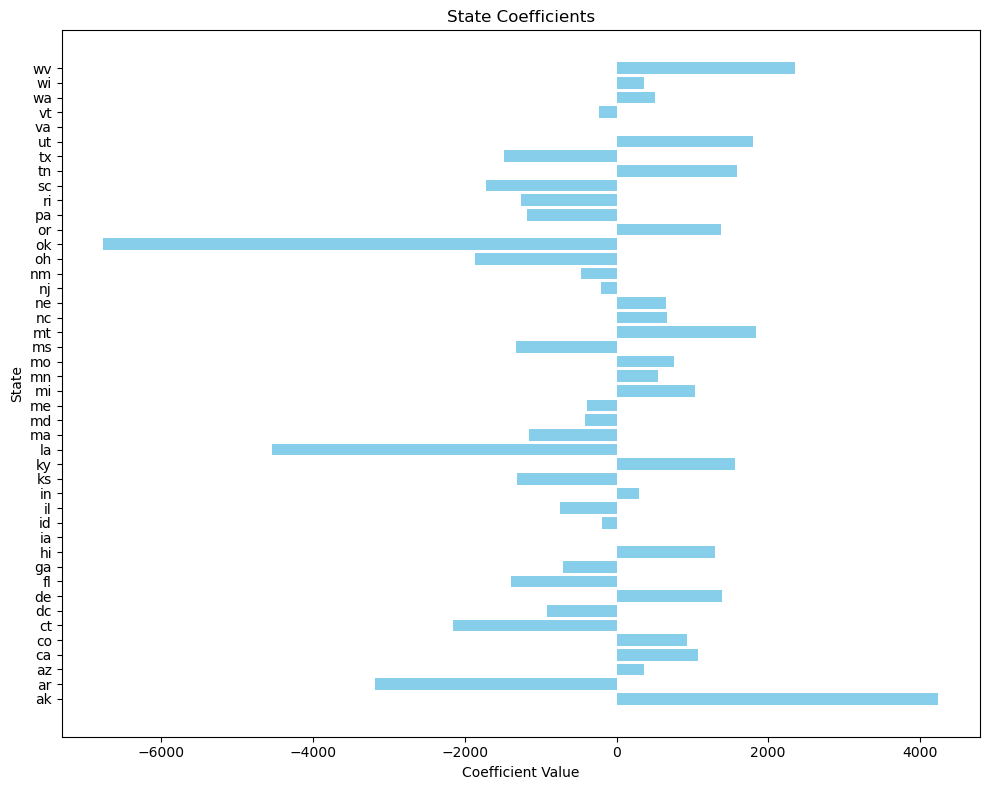

In [64]:
# Function to extract significant features from a fitted Lasso pipeline
def get_significant_features_from_lasso(pipeline, numerical_features, categorical_features):
    # Ensure the pipeline is fitted
    if not hasattr(pipeline.named_steps['preprocessor'], 'transformers_'):
        raise ValueError("The preprocessor (ColumnTransformer) must be fitted before extracting significant features.")
    
    # Get the preprocessor and regressor from the pipeline
    preprocessor = pipeline.named_steps['preprocessor']
    lasso_model = pipeline.named_steps['regressor']
    
    # Initialize an empty list to store feature names
    feature_names = []

    # Extract feature names for numerical features
    num_transformer = preprocessor.transformers_[0][1]  # Assuming 'num' is the first transformer
    if hasattr(num_transformer, 'named_steps') and 'poly' in num_transformer.named_steps:
        poly = num_transformer.named_steps['poly']
        num_feature_names = poly.get_feature_names_out(numerical_features)
        feature_names.extend(num_feature_names)

    # Extract feature names for categorical features
    cat_transformer = preprocessor.transformers_[1][1]  # Assuming 'cat' is the second transformer
    if hasattr(cat_transformer, 'get_feature_names_out'):
        cat_feature_names = cat_transformer.get_feature_names_out(categorical_features)
        feature_names.extend(cat_feature_names)

    # Get the coefficients from the Lasso model
    coefficients = lasso_model.coef_

    # Ensure the number of coefficients matches the number of feature names
    if len(coefficients) != len(feature_names):
        raise ValueError(f"Mismatch between number of coefficients ({len(coefficients)}) and feature names ({len(feature_names)}). Check your pipeline structure.")

    # Filter for significant features (non-zero coefficients)
    significant_features = [(feature, coef) for feature, coef in zip(feature_names, coefficients) if coef != 0]

    return significant_features

# Example usage
try:
    # Ensure the pipeline is fitted
    lasso_pipeline.fit(X_train, y_train)

    # Extract significant features
    significant_features = get_significant_features_from_lasso(lasso_pipeline, numerical_features, categorical_features)


    # Populate feature_info_dict with the significant features and their coefficients
    feature_info_dict = {feature: coef for feature, coef in significant_features}

    # Filter and plot 'state_' features
    state_features = {k: v for k, v in feature_info_dict.items() if k.startswith('state_')}
    labels = [k.replace('state_', '') for k in state_features.keys()]
    values = list(state_features.values())

    # Create the plot
    plt.figure(figsize=(10, 8))
    plt.barh(labels, values, color='skyblue')
    plt.title('State Coefficients')
    plt.xlabel('Coefficient Value')
    plt.ylabel('State')
    plt.tight_layout()
    plt.show()

    # Print the significant features
    #print("Significant Features:")
    #for feature, coef in significant_features:
        #print(f"{feature}: {coef}")
except Exception as e:
    print(f"Error: {e}")

# Filter and plot 'state_' features


_The significant coeeficients on the state are likely an indication of over training. The states shouldn't have a an impact of more than a few percent on the price of a car since cars are a mobile asset.  It's probably best to rerun with out the states as an input_

In [65]:
print(vehicles_df.shape)

# Downsample the dataset to a smaller size for faster processing
vehicles_ds_df = vehicles_df
print(vehicles_ds_df.shape)
vehicles_ds_df

# Define the features and target
categorical_features = 	['manufacturer', 
                         'condition', 
                         'cylinders',	
                         'fuel',	
                         'title_status',
                         'transmission',	
                         'drive', 
                         'size', 
                         'type', 
                         'paint_color']
                         
numerical_features = ['odometer', 'age']
target = 'price'

# Split the data into features (X) and target (y)
X = vehicles_ds_df[categorical_features + numerical_features]
y = vehicles_ds_df[target]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


(78777, 14)
(78777, 14)


In [66]:
# Define the preprocessor
def create_preprocessor(degree):
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('poly', PolynomialFeatures(degree=degree, include_bias=False)), 
                ('scaler', StandardScaler())
            ]), numerical_features),
            ('cat', OneHotEncoder(), categorical_features)
        ]
    )
    return preprocessor

# Define the Lasso pipeline
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', create_preprocessor(degree=2)),  # Initial degree (overridden by GridSearchCV)
    ('regressor', Lasso(random_state=42))
])

# Define the parameter grid for Lasso
lasso_param_grid = {
    'preprocessor__num__poly__degree': [1, 2, 3, 4, 5],  # Polynomial degrees
    'regressor__alpha': [0.01, 0.1, 1.0, 10, 100, 1000]  # Regularization strengths
}

# Perform GridSearchCV for Lasso
lasso_grid_search = GridSearchCV(lasso_pipeline, lasso_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
lasso_grid_search.fit(X_train, y_train)

# Print the best parameters and score for Lasso
print("Best Lasso Parameters:", lasso_grid_search.best_params_)
print("Best Lasso Score:", -lasso_grid_search.best_score_)

# Define the Ridge pipeline
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', create_preprocessor(degree=2)),  # Initial degree (overridden by GridSearchCV)
    ('regressor', Ridge(random_state=42))
])

# Define the parameter grid for Ridge
ridge_param_grid = {
    'preprocessor__num__poly__degree': [1, 2, 3, 4, 5],  # Polynomial degrees
    'regressor__alpha': [0.01, 0.1, 1.0, 10, 100, 1000]  # Regularization strengths
}

# Perform GridSearchCV for Ridge
ridge_grid_search = GridSearchCV(ridge_pipeline, ridge_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
ridge_grid_search.fit(X_train, y_train)

# Print the best parameters and score for Ridge
print("Best Ridge Parameters:", ridge_grid_search.best_params_)
print("Best Ridge Score:", -ridge_grid_search.best_score_)

c:\Users\stepa\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2200841690357.8066, tolerance: 975953295.1360685
  model = cd_fast.sparse_enet_coordinate_descent(


Best Lasso Parameters: {'preprocessor__num__poly__degree': 5, 'regressor__alpha': 0.01}
Best Lasso Score: 70488257.2092332
Best Ridge Parameters: {'preprocessor__num__poly__degree': 5, 'regressor__alpha': 1.0}
Best Ridge Score: 70324509.60469374


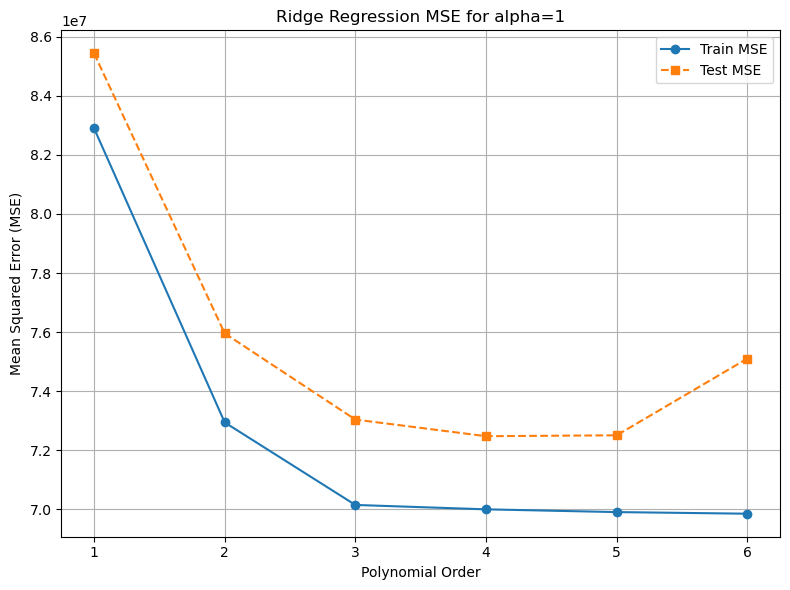

In [67]:
# List of polynomial orders to evaluate
orders = [1, 2, 3, 4, 5, 6]
alpha = 1  # Fixed alpha value

# Store results
train_mse_list = []
test_mse_list = []

for order in orders:
    # Update the Ridge pipeline with the current polynomial order
    ridge_pipeline.set_params(preprocessor__num__poly__degree=order, regressor__alpha=alpha)
    
    # Fit the pipeline to the training data
    ridge_pipeline.fit(X_train, y_train)
    
    # Predict on training and testing sets
    y_train_pred = ridge_pipeline.predict(X_train)
    y_test_pred = ridge_pipeline.predict(X_test)
    
    # Calculate MSE for training and testing sets
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    
    # Store the results
    train_mse_list.append(train_mse)
    test_mse_list.append(test_mse)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(orders, train_mse_list, label='Train MSE', marker='o', linestyle='-')
plt.plot(orders, test_mse_list, label='Test MSE', marker='s', linestyle='--')
plt.xlabel('Polynomial Order')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Ridge Regression MSE for alpha=1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [68]:
# Update the Lasso pipeline with the current polynomial order
lasso_pipeline.set_params(preprocessor__num__poly__degree=3, regressor__alpha=1)

# Fit the pipeline to the training data
lasso_pipeline.fit(X_train, y_train)

# Predict on training and testing sets
y_train_pred = ridge_pipeline.predict(X_train)
y_test_pred = ridge_pipeline.predict(X_test)

print("Mean Squared Error on Test Set:", mean_squared_error(y_test, y_test_pred))


Mean Squared Error on Test Set: 75100878.25868022


c:\Users\stepa\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135049803585.51318, tolerance: 975953295.1360685
  model = cd_fast.sparse_enet_coordinate_descent(


In [69]:
# Function to extract significant features from a fitted Lasso pipeline
def get_significant_features_from_lasso(pipeline, numerical_features, categorical_features):
    # Ensure the pipeline is fitted
    if not hasattr(pipeline.named_steps['preprocessor'], 'transformers_'):
        raise ValueError("The preprocessor (ColumnTransformer) must be fitted before extracting significant features.")
    
    # Get the preprocessor and regressor from the pipeline
    preprocessor = pipeline.named_steps['preprocessor']
    lasso_model = pipeline.named_steps['regressor']
    
    # Initialize an empty list to store feature names
    feature_names = []

    # Extract feature names for numerical features
    num_transformer = preprocessor.transformers_[0][1]  # Assuming 'num' is the first transformer
    if hasattr(num_transformer, 'named_steps') and 'poly' in num_transformer.named_steps:
        poly = num_transformer.named_steps['poly']
        num_feature_names = poly.get_feature_names_out(numerical_features)
        feature_names.extend(num_feature_names)

    # Extract feature names for categorical features
    cat_transformer = preprocessor.transformers_[1][1]  # Assuming 'cat' is the second transformer
    if hasattr(cat_transformer, 'get_feature_names_out'):
        cat_feature_names = cat_transformer.get_feature_names_out(categorical_features)
        feature_names.extend(cat_feature_names)

    # Get the coefficients from the Lasso model
    coefficients = lasso_model.coef_

    # Ensure the number of coefficients matches the number of feature names
    if len(coefficients) != len(feature_names):
        raise ValueError(f"Mismatch between number of coefficients ({len(coefficients)}) and feature names ({len(feature_names)}). Check your pipeline structure.")

    # Filter for significant features (non-zero coefficients)
    significant_features = [(feature, coef) for feature, coef in zip(feature_names, coefficients) if coef != 0]

    return significant_features

# Example usage
try:
    # Ensure the pipeline is fitted
    lasso_pipeline.fit(X_train, y_train)

    # Extract significant features
    significant_features = get_significant_features_from_lasso(lasso_pipeline, numerical_features, categorical_features)

    feature_info_dict = {}
    # Print the significant features
    print("Significant Features:")
    for feature, coef in significant_features:
        #print(f"{feature}: {coef}")
        feature_info_dict[feature] = coef
    
except Exception as e:
    print(f"Error: {e}")

Significant Features:


c:\Users\stepa\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135049803585.51318, tolerance: 975953295.1360685
  model = cd_fast.sparse_enet_coordinate_descent(


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

_Plotting the coeficients can be used to help inform the car dealer about what drives the cost of vehicles_

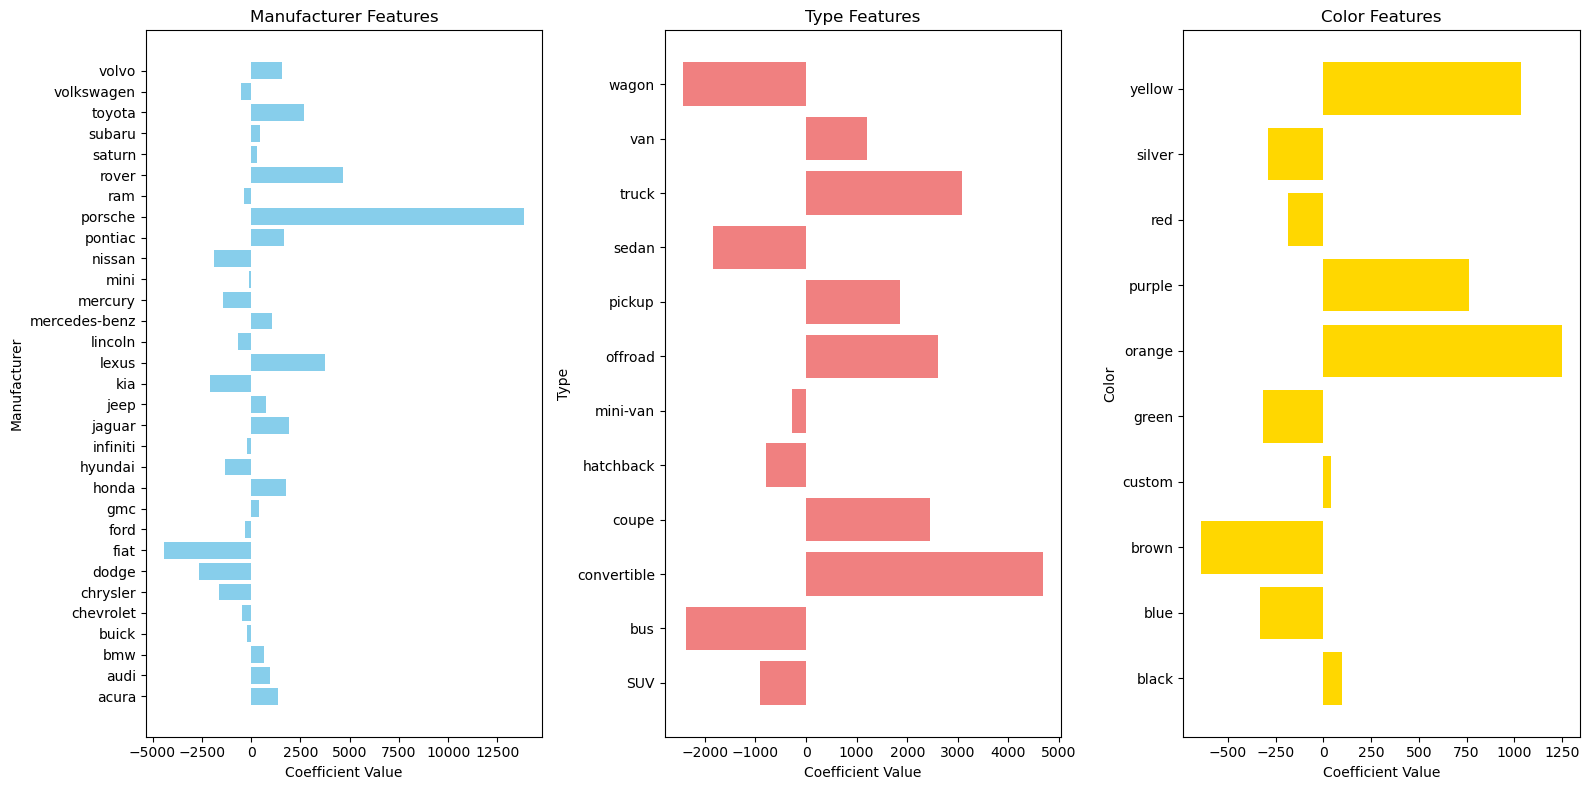

In [70]:
# Create subplots for manufacturer, type, and color features
fig, axes = plt.subplots(1, 3, figsize=(16, 8))

# Filter and plot 'manufacturer_' features
manufacturer_features = {k: v for k, v in feature_info_dict.items() if k.startswith('manufacturer_')}
labels = [k.replace('manufacturer_', '') for k in manufacturer_features.keys()]
values = list(manufacturer_features.values())
axes[0].barh(labels, values, color='skyblue')
axes[0].set_title('Manufacturer Features')
axes[0].set_xlabel('Coefficient Value')
axes[0].set_ylabel('Manufacturer')

# Filter and plot 'type_' features
type_features = {k: v for k, v in feature_info_dict.items() if k.startswith('type_')}
labels = [k.replace('type_', '') for k in type_features.keys()]
values = list(type_features.values())
axes[1].barh(labels, values, color='lightcoral')
axes[1].set_title('Type Features')
axes[1].set_xlabel('Coefficient Value')
axes[1].set_ylabel('Type')

# Filter and plot 'paint_color_' features
color_features = {k: v for k, v in feature_info_dict.items() if k.startswith('paint_color_')}
labels = [k.replace('paint_color_', '') for k in color_features.keys()]
values = list(color_features.values())
axes[2].barh(labels, values, color='gold')
axes[2].set_title('Color Features')
axes[2].set_xlabel('Coefficient Value')
axes[2].set_ylabel('Color')

# Adjust layout
plt.tight_layout()
plt.show()

Text(0.5, 0, 'Coefficient Value')

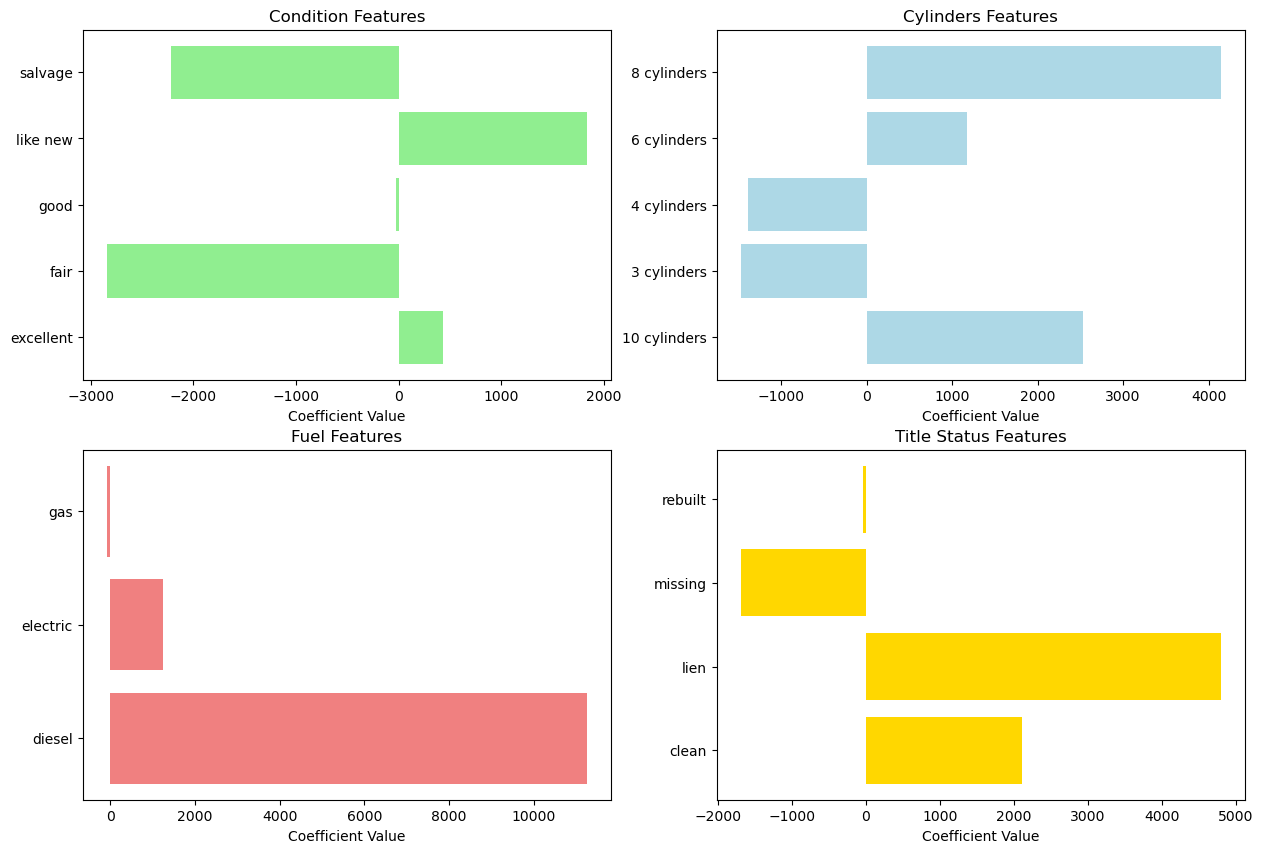

In [71]:
# Create subplots for condition, cylinders, fuel, and title_status
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Filter and plot 'condition_' features
condition_features = {k: v for k, v in feature_info_dict.items() if k.startswith('condition_')}
labels = [k.replace('condition_', '') for k in condition_features.keys()]
values = list(condition_features.values())
axes[0, 0].barh(labels, values, color='lightgreen')
axes[0, 0].set_title('Condition Features')
axes[0, 0].set_xlabel('Coefficient Value')

# Filter and plot 'cylinders_' features
cylinders_features = {k: v for k, v in feature_info_dict.items() if k.startswith('cylinders_')}
labels = [k.replace('cylinders_', '') for k in cylinders_features.keys()]
values = list(cylinders_features.values())
axes[0, 1].barh(labels, values, color='lightblue')
axes[0, 1].set_title('Cylinders Features')
axes[0, 1].set_xlabel('Coefficient Value')

# Filter and plot 'fuel_' features
fuel_features = {k: v for k, v in feature_info_dict.items() if k.startswith('fuel_')}
labels = [k.replace('fuel_', '') for k in fuel_features.keys()]
values = list(fuel_features.values())
axes[1, 0].barh(labels, values, color='lightcoral')
axes[1, 0].set_title('Fuel Features')
axes[1, 0].set_xlabel('Coefficient Value')

# Filter and plot 'title_status_' features
title_status_features = {k: v for k, v in feature_info_dict.items() if k.startswith('title_status_')}
labels = [k.replace('title_status_', '') for k in title_status_features.keys()]
values = list(title_status_features.values())
axes[1, 1].barh(labels, values, color='gold')
axes[1, 1].set_title('Title Status Features')
axes[1, 1].set_xlabel('Coefficient Value')


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

## _Results_

_Looking at the coefficients of our model we can see which items drive the cost of car positive or negative_

- _Older cars with higher milage sell for less_
- _The Manufacturer has a significant impact on the price but not as significant as the type of car.  Porsche is the most expensive brand._
    - _The most expensive trucks, pickups, coupes, and convertables tend to have higher sale prices_
- _The better the condition of the car the more money it will sell for_
- _White, Black, and Gray colors will fetch a higher price. (So will orange and yellow but these results are likely skewed by sports cars)_
- _Bigger engines sell for more Money_
- _Exotic colors (Purple, yellow or orange) tend to sell for more.  Though this is likely due to their correlation with high end sports cars._

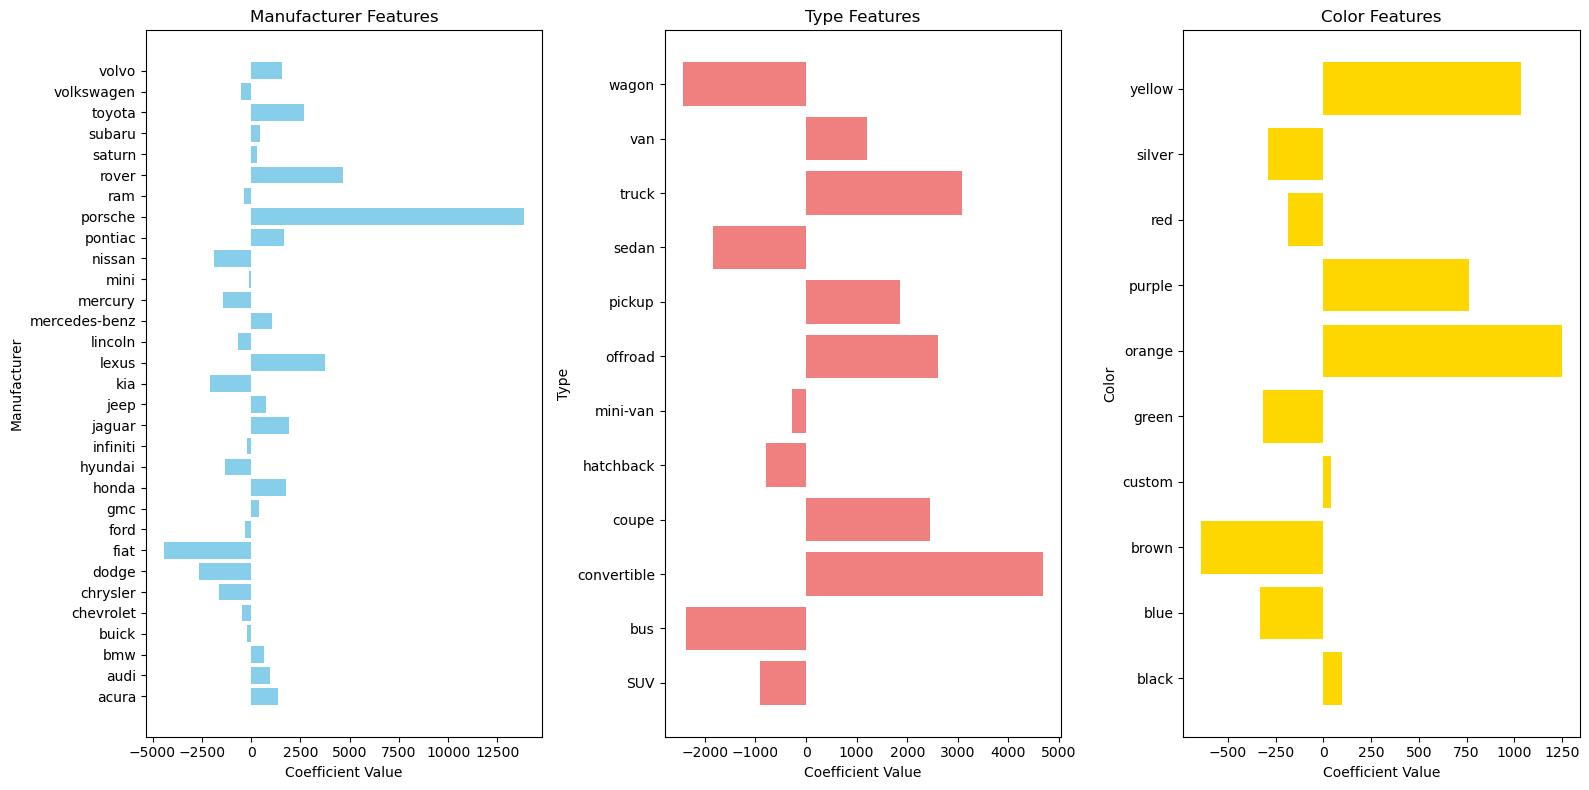

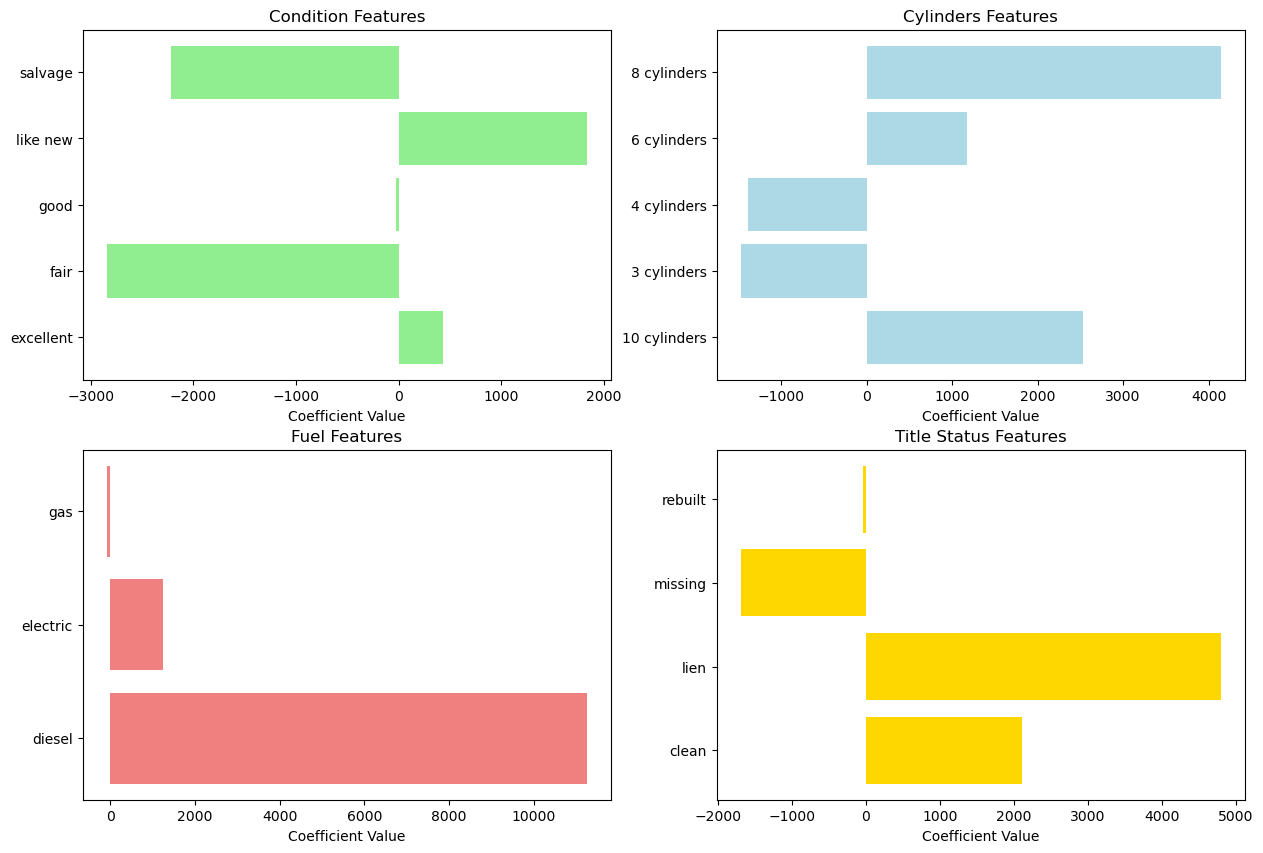

## _Future Actions_

_The most appropriate way to generate a model for the price of a car is likely by using a model for each Make and Model with its Odometer, Age and Color. You could quickly run an assessment based on this to asess prices.  This could be done if the information in the model section was usable_
